## Part 1 - Data Preprocessing

In [ ]:
!pip install MiniSom

In [ ]:
from minisom import MiniSom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import bone, pcolor, colorbar, plot, show
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Dateset can be found in the following link:
#https://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval)

df = pd.read_csv('Credit_Card_Applications.csv')
df

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


Separating the Dataset for Customers that got their CC Application Approved and those who didn't

In [ ]:
#Normally we'd exclude the customer ID in analysis. However, in a SOM, they would make no difference since the values are similar, so they would all cluster together
#In addition, we're going to keep the customer ID so that we can show at the end which customer IDs were most likely frauds
X = df.iloc[:, :-1].values #getting all the rows (customers), and getting all the columns, except the last one which is whether they got the CC approved or not
print(X[0])
print(X.shape) #690 rows of data with 14 columns as expected

[1.5776156e+07 1.0000000e+00 2.2080000e+01 1.1460000e+01 2.0000000e+00
 4.0000000e+00 4.0000000e+00 1.5850000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 2.0000000e+00 1.0000000e+02 1.2130000e+03]
(690, 15)


In [ ]:
y = df['Class'].values #setting the Class column as our label where 0 is CC not approved and 1 is CC approved
print(y[0:10] )

[0 0 0 1 1 1 0 1 0 0]


Feature Scaling

In [ ]:
#We need to normalize the data between -1 and 1, and we normalize the data because NN typically train better due to the way weights and biases update after normalization
scaler = MinMaxScaler(feature_range=(0,1)) #so here we're scaling the values down from 0 to 1

X = scaler.fit_transform(X) #now we're fitting it but also transforming X to be scaled
print(X[0]) #notice all the values are now scaled between 0 and 1
print(X.shape) #notice 

[0.84268147 1.         0.12526316 0.40928571 0.5        0.23076923
 0.375      0.05561404 0.         0.         0.         1.
 0.5        0.05       0.01212   ]
(690, 15)


# Part 2 - Training the SOM

In [ ]:
som = MiniSom(x=12, y=12, input_len= 15, sigma= 1.0, learning_rate = 0.5) #our grid size will be 12x12, since we don't have too much data (only 690 customers). But if you want to make it more accurate, we can always increase the grid size
#input length of 15 which are our 15 columns. Sigma is the radius of the different centroids in the grid, and we'll use it's default value of 1. Also using default learning rate

som.random_weights_init(X) #using the random_weights_init method from MiniSom to randomly initialize our centroids

som.train_random(data = X, num_iteration = 150) 

# Part 3 - Visualize the SOM

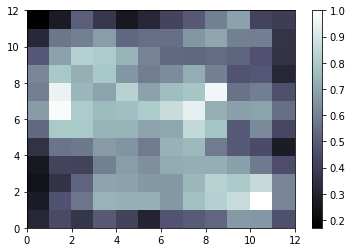

In [ ]:
bone() #providing us with the window (bones of our figure)
pcolor(som.distance_map().T) #returning the transposed matrix of all the mean interneuron distances for all the nodes
colorbar() #so with this legend, we can see the highest Mean Interneuron Distances (MID), are the white colours, meaning these guys are the outliers (the outlying nodes are far from the rules, therefore are the frauds)
#so here we can tell that points (1,6),(8,7),(10,1) seem to be frauds

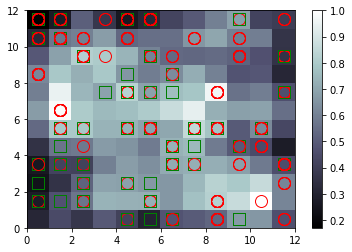

In [ ]:
bone() #providing us with the window (bones of our figure)
pcolor(som.distance_map().T) #returning the transposed matrix of all the mean interneuron distances for all the nodes
colorbar() 

#going to mark the figure above with red circles if the customer didn't get approval and green squares if they did get approval
markers = ['o', 's'] #using 2 markers, using circle and square
colors = ['r', 'g'] #using 2 colours red and green

#Below, i will represent each customer and x will repesent the customer information
#in the plot, w[0] (first coordinate) and w[1] (second coordinate) is the coordinate of the lower left corner of the square, so we added 0.5 and 0.5 to put it in the center 
#y[i] means the approval result for customer i, and setting markers red circle as no approval and green square as yes approval
for i, x in enumerate(X):
    w = som.winner(x) #grabbing the winning node for custom x
    plot(w[0] +0.5, 
         w[1] +0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markeredgewidth = 1,
         markersize = 12,
         markerfacecolor = 'None')

## Part 4 - Marking the Frauds

In [ ]:
mappings = som.win_map(X) #now we're grabbing the customers within each coordinate
frauds1 = mappings[(1,6)] 
frauds2 = mappings[(8,7)]
frauds3 = mappings[(10,1)]

print(len(frauds1), "frauds in coordinate (1,6)")
print(len(frauds2), "frauds in coordinate (8,7)")
print(len(frauds3), "fraud in coordinate (10,1)")

10 frauds in coordinate (1,6)
11 frauds in coordinate (8,7)
1 fraud in coordinate (10,1)


In [ ]:
frauds = np.concatenate((frauds1, frauds2, frauds3), axis = 0)
#frauds = np.concatenate((mappings[(1,1)], mappings[(4,1)]), axis = 0)

frauds = scaler.inverse_transform(frauds)

In [ ]:
print('Fraud Customer IDs')
count = 0
for i in frauds[:, 0]:
  print(int(i))
  count += 1

print(count, "frauds in total")

Fraud Customer IDs
15719940
15711742
15761733
15770995
15793825
15696361
15736399
15766734
15667934
15750104
15651868
15716082
15651460
15672637
15752344
15736533
15779207
15611409
15636454
15608916
15615296
15605872
22 frauds in total
